# Tổng quan cuộc thi
Cuộc thi này được tổ chức bởi Home Depot trên Kaggle.com. Home Depot muốn xây dựng một đề xuất tìm kiếm linh hoạt hơn để hỗ trợ hoạt động bán hàng trực tuyến của mình. Với việc đối sánh cụm từ tìm kiếm của khách hàng với thuộc tính / mô tả của sản phẩm, khách hàng sẽ dễ dàng tìm thấy đúng sản phẩm họ muốn hơn. Do đó, quá trình lựa chọn được cải thiện và khách hàng sẽ tìm được những sản phẩm phù hợp

# Input:
Gồm 4 tập dữ liệu csv (train, test, attributes, product_descriptions) chứa sản phẩm và cụm từ tìm kiếm thực tế của khách hàng từ trang web của Home Depot cùng với mức độ liên quan (relevance) đã được đánh giá bởi ít nhất ba chuyên gia đánh giá

Relevance là một số thực từ 1 đến 3 (1 cho không liên quan và 3 cho kết hợp hoàn hảo)

# Mục tiêu:
Từ các tập dữ liệu được cung cấp, xây dựng mô hình để dự đoán mức độ phù hợp (relevance) cho từng cặp được liệt kê trong bộ dữ liệu test.csv

# Output:
File csv chứa id sản phẩm và mức độ liên quan (relevance)

# Import Libraries

In [1]:
import time
start_time = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import os
# Any results you write to the current directory are saved as output.
import json
import warnings; warnings.filterwarnings("ignore");

from sklearn.ensemble import RandomForestRegressor
#from sklearn import pipeline
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, make_scorer
#from nltk.metrics import edit_distance
from nltk.stem.porter import *
stemmer = PorterStemmer()
#from nltk.stem.snowball import SnowballStemmer #0.003 improvement but takes twice as long as PorterStemmer
from bs4 import BeautifulSoup
import re
from scipy.stats import spearmanr
import random
random.seed(2016)
from scipy.stats import norm  
import seaborn as sns # data visualization
%matplotlib inline
import matplotlib.pyplot as plt

# Tổng quan về dữ liệu
train.csv - tập dữ liệu dùng để huấn luyện chứa sản phẩm, cụm từ tìm kiếm và mức độ liên quan
test.csv - bộ thử nghiệm, chứa các sản phẩm và cụm từ tìm kiếm
product_descriptions.csv - chứa mô tả dạng text của từng sản phẩm
attributes.csv - thuộc tính của sản phẩm, cung cấp thông tin mở rộng về một tập hợp con của các sản phẩm (thường đại diện cho các thông số kỹ thuật chi tiết). Không phải mọi sản phẩm sẽ đều có thuộc tính.
sample_submission.csv - một tệp hiển thị đúng định dạng gửi
relevance_instructions.docx - các hướng dẫn được cung cấp cho người đánh giá
# Các trường dữ liệu
* id - trường Id duy nhất đại diện cho một cặp (search_term, product_uid) 
* product_uid - id cho các sản phẩm
* product_title - tiêu đề sản phẩm
* product_description - mô tả text của sản phẩm (có thể chứa nội dung HTML)
* search_term - cụm từ tìm kiếm
* relevane - mức trung bình của xếp hạng mức độ liên quan cho một id nhất định
* name - tên thuộc tính
* value - giá trị của thuộc tính

# Load data from csv file

In [2]:
path = "../input/home-depot-product-search-relevance-data/"
train_df = pd.read_csv(path + "train.csv", encoding="ISO-8859-1") #update here
test_df = pd.read_csv(path + "test.csv", encoding="ISO-8859-1") #update here
desc_df = pd.read_csv(path + "product_descriptions.csv", encoding="ISO-8859-1") #update here
attribute_df = pd.read_csv(path + "attributes.csv", encoding="ISO-8859-1") #update here
print(train_df.shape)
train_df.head(1)

(74067, 5)


,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0


In [3]:
def get_df_info(df):
    print(f"df shape: \n",df.shape)
    print(f"df data has {df.isnull().values.sum()} null values:")
    print(f"df columns: \n",df.columns)
    print(f"df data types: \n",df.dtypes)
    return df.head(10)

# Train Data
* Gồm các cột: product_uid, product_title, search_term, relevance và 74067 hàng chứa thông tin các trường của sản phẩm tương ứng
* Product_uid là số nhận dạng duy nhất cho mỗi sản phẩm.
* Tập train không có giá trị Null
* Đối với mỗi sản phẩm, thường có nhiều hàng tức là nhiều truy vấn tìm kiếm với điểm mức độ liên quan của chúng.
* Tập train gồm:
  * 54667 product_uid
  * 11795 search_term
  * 94731 product_title
* Nhiều sản phẩm xuất hiện nhiều lần trong tập train

In [4]:
get_df_info(train_df)

df shape: 
 (74067, 5)
df data has 0 null values:
df columns: 
 Index(['id', 'product_uid', 'product_title', 'search_term', 'relevance'], dtype='object')
df data types: 
 id                 int64
product_uid        int64
product_title     object
search_term       object
relevance        float64
dtype: object


,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67
5,18,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,3.00
6,20,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwave over stove,2.67
7,21,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,3.00
8,23,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,emergency light,2.67
9,27,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,3.00


In [5]:
print("there are {} product_uid".format(len(train_df.product_uid.unique())))
print("there are {} products_title".format(len(train_df.product_title.unique())))
print("there are {} search query ".format(len(train_df.search_term.unique())))

there are 54667 product_uid
there are 53489 products_title
there are 11795 search query 


**Biểu đồ thể hiện sự phân bổ của relevance trong tập train**

* Số lượng sản phẩm đạt mức tương quan cao với từ tìm kiếm (relevance=3) chiếm số lượng lớn nhất
* Relevance = {1,25, 1,5, 1,75, 2,25, 2,5, 2,75} xảy ra với tần suất rất thấp.

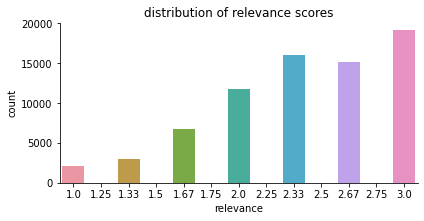

In [6]:
sns.catplot(x='relevance', kind='count', data=train_df, height=3, aspect=2)
plt.title('distribution of relevance scores')
plt.show()

# Test Data
* Chứa các cột: product_uid, product_title, search_term và 166693 hàng
* Tập test không chứa dữ liệu Null
* Gần 1 nửa số sản phẩm của tập train nằm trong tập test (27699 sản phẩm)
* Tập test gồm:
  * 97460 product_uid
  * 94731 products_title
  * 22427 search_term

In [7]:
get_df_info(test_df)

df shape: 
 (166693, 4)
df data has 0 null values:
df columns: 
 Index(['id', 'product_uid', 'product_title', 'search_term'], dtype='object')
df data types: 
 id                int64
product_uid       int64
product_title    object
search_term      object
dtype: object


,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
5,8,100001,Simpson Strong-Tie 12-Gauge Angle,wood connectors
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit
7,11,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath drain kit
8,12,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,one piece tub shower
9,13,100004,Grape Solar 265-Watt Polycrystalline Solar Pan...,solar panel


In [8]:
print("there are {} product_uid".format(len(test_df.product_uid.unique())))
print("there are {} products_title".format(len(test_df.product_title.unique())))
print("there are {} search query ".format(len(test_df.search_term.unique())))

there are 97460 product_uid
there are 94731 products_title
there are 22427 search query 


In [9]:
# pip install matplotlib-venn

In [10]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

**Biểu đồ Venn thể hiện độ tương quan của sản phẩm trong tập train và test**

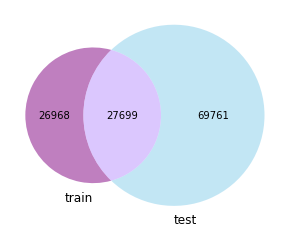

In [11]:
venn2([set(train_df["product_uid"]), set(test_df["product_uid"])], set_labels=('train', 'test'),set_colors=('purple', 'skyblue'),alpha = 0.5)
plt.show()

# Description data
* Gồm 2 cột(product_id và product_description) và 124428 hàng
* product_description chứa mô tả văn bản của từng sản phẩm bao gồm số và các ký tự, hữu ích trong việc tìm kiếm sản phẩm
* Tập description không chứa giá trị Null
* Tập description có:
  * 124428 product_uid
  * 110128 product_description

In [12]:
get_df_info(desc_df)

df shape: 
 (124428, 2)
df data has 0 null values:
df columns: 
 Index(['product_uid', 'product_description'], dtype='object')
df data types: 
 product_uid             int64
product_description    object
dtype: object


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...
5,100006,Achieving delicious results is almost effortle...
6,100007,The Quantum Adjustable 2-Light LED Black Emerg...
7,100008,The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8,100009,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9,100010,Valley View Industries Metal Stakes (4-Pack) a...


In [13]:
print("there are {} product_uid".format(len(desc_df.product_uid.unique())))
print("there are {} product_description".format(len(desc_df.product_description.unique())))

there are 124428 product_uid
there are 110128 product_description


**Biểu đồ thể hiện sự tương quan giữa tập train và desc của sản phẩm**

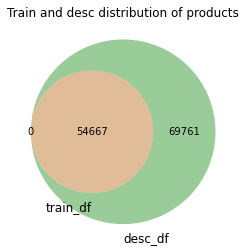

In [14]:
set1 = set(train_df['product_uid'].values)
set2 = set(desc_df['product_uid'].values)

venn2([set1, set2], ('train_df', 'desc_df'))
plt.title('Train and desc distribution of products')
plt.show()

# Attribute data
* Gồm 3 cột(product_uid, name, value) và 2.044.803 hàng
* chứa một số thông tin bổ sung về một tập hợp con các sản phẩm.
* Tập thuộc tính chứa 2594 giá trị null.
* Mỗi sản phẩm trong tệp thuộc tính.csv có nhiều thuộc tính. Số lượng thuộc tính tối thiểu cho một sản phẩm là 5 và tối đa là 88. Nhưng không phải tất cả các sản phẩm trong tệp train.csv đều được tìm thấy trong tệp thuộc tính.csv. Tổng số 16263 trên tổng số 54667 sản phẩm không có thuộc tính
* name (thương hiệu) là thuộc tính phổ biến nhất được tìm thấy trong 86.250 trường hợp trong tệp attributes.csv

In [15]:
get_df_info(attribute_df)

df shape: 
 (2044803, 3)
df data has 2594 null values:
df columns: 
 Index(['product_uid', 'name', 'value'], dtype='object')
df data types: 
 product_uid    float64
name            object
value           object
dtype: object


,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel
5,100001.0,Bullet06,Galvanized for extra corrosion resistance
6,100001.0,Bullet07,Install with 10d common nails or #9 x 1-1/2 in...
7,100001.0,Gauge,12
8,100001.0,Material,Galvanized Steel
9,100001.0,MFG Brand Name,Simpson Strong-Tie


max number of attributes for a single product 88
min number of attributes for a single product 5



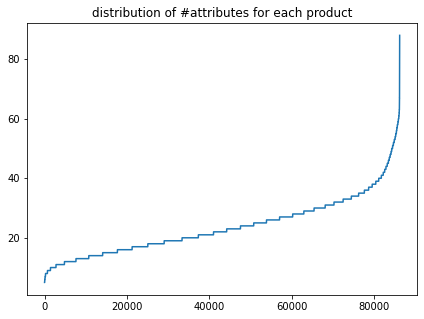

In [16]:
grp_df = attribute_df.groupby(['product_uid'])
print('max number of attributes for a single product', grp_df.count()['value'].max())
print('min number of attributes for a single product', grp_df.count()['value'].min())
print('')

plt.figure(figsize=(7,5))
plt.plot(np.sort(grp_df.count()['value']))
plt.title('distribution of #attributes for each product')
plt.show()

**Biểu đồ thể hiện sự tương quan của train.csv và attributes.csv**

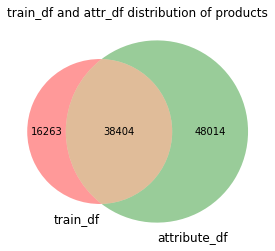

In [17]:
set1 = set(train_df['product_uid'].values)
set2 = set(attribute_df['product_uid'].values)

venn2([set1, set2], ('train_df', 'attribute_df'))
plt.title('train_df and attr_df distribution of products')
plt.show()

**Kiểm tra xem product_uids có bất kỳ mối tương quan nào với điểm mức độ liên quan hay không**

Spearmans correlation between product_uid and relevance class 0.08922860613250413



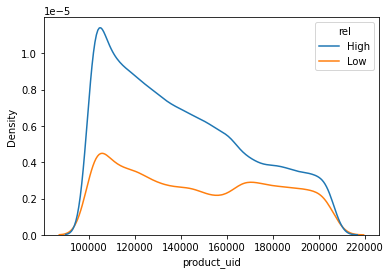

In [18]:
temp_ = train_df.copy()
temp_['rel'] = temp_['relevance'].apply(lambda x: 'High' if x > 2 else 'Low')

corr, _ = spearmanr(temp_['product_uid'], temp_['rel'])
print('Spearmans correlation between product_uid and relevance class', corr)
print('')

sns.kdeplot(data=temp_, x="product_uid", hue="rel")
plt.plot()
plt.show()

In [19]:
# hàm nối thuộc tính
def merge_attributes(df):
    product_uids = df['product_uid'].values
    temp = attribute_df.loc[attribute_df['product_uid'].isin(product_uids)].fillna('')  
    temp['name_value'] = temp['name'] + ' ' + temp['value']
    temp['attr'] = temp.groupby(['product_uid'])['name_value'].transform(lambda x: ' '.join(x))
    temp = temp.drop_duplicates('product_uid')[['product_uid', 'attr']]
    df = pd.merge(df, temp, on='product_uid', how='left').set_index(df.index)
    return df

In [20]:
# hàm nối với brand
def merge_brand(df):
    product_uids = df['product_uid'].values
    temp = attribute_df.loc[attribute_df['product_uid'].isin(product_uids)]  
    brands = temp[temp['name']=='MFG Brand Name']
    brands_temp = brands[['product_uid','value']]
    df = pd.merge(df, brands_temp, on='product_uid', how='left').set_index(df.index)
    df.rename(columns = {'value':'brand'}, inplace = True) 
    return df

In [21]:
# hàm nối với mô tả
def merge_description(df):
    df = pd.merge(df, desc_df, on='product_uid', how='left').set_index(df.index)
  #tách các từ được nối trong mô tả. 
    df['product_description'] = df['product_description'].apply(lambda x: ' '.join(re.findall(r'[A-Z]?[^A-Z\s]+|[A-Z]+', x)))
    return df

# Preprocessing data
Để có cái nhìn tổng quát về dữ liệu của chúng tôi, chúng tôi sẽ hợp nhất tập train và test. Sau đó hợp nhất tất cả các thuộc tính, mô tả và thương hiệu với train_df.

In [22]:
num_train = train_df.shape[0]
df_clean = pd.concat((train_df, test_df), axis=0, ignore_index=True)
df_clean = merge_attributes(df_clean)
# test_df = merge_attributes(test_df)
df_clean = merge_description(df_clean)
# test_df = merge_description(test_df)
df_clean = merge_brand(df_clean)
# test_df = merge_brand(test_df)
df_clean.drop(['attr'],axis=1, inplace=True)
print(df_clean.shape)
df_clean.columns
df_clean.head()

(240760, 7)


,id,product_uid,product_title,search_term,relevance,product_description,brand
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta


Ta thấy rằng train_df có nhiều giá trị rỗng. Những điều này xảy ra khi hợp nhất các thuộc tính, vì nhiều sản phẩm trong tập train không có thuộc tính.

In [23]:
for col in df_clean.columns:
    print('{} has {} null values'.format(col, df_clean[col].isna().values.sum()))

id has 0 null values
product_uid has 0 null values
product_title has 0 null values
search_term has 0 null values
relevance has 166693 null values
product_description has 0 null values
brand has 46137 null values


# Điền giá trị rỗng
* Có thể thấy rằng các giá trị null chỉ xảy ra trong trường 'brand'.
* Thương hiệu của một sản phẩm thường hiện diện trong một vài từ đầu tiên của tiêu đề.
* 99% thương hiệu có độ dài từ bốn từ trở xuống. Vì vậy, chủ yếu, thương hiệu nên hiện diện trong 4 từ đầu tiên của tiêu đề.
* Đầu tiên,lưu trữ tất cả các thương hiệu duy nhất trong một danh sách “unique_brands”.
* Bây giờ, đối với bất kỳ hàng nào có nhãn hiệu rỗng, kiểm tra xem bốn từ đầu tiên của tiêu đề sản phẩm đó có xuất hiện trong danh sách unique_brands hay không. Nếu không, sau đó kiểm tra ba từ đầu tiên và cứ tiếp tục như vậy cho đến từ đầu tiên.

In [24]:
unique_brands = np.unique(df_clean['brand'].dropna().values)
null_df = df_clean[df_clean['brand'].isnull()]

In [25]:
def split_n(n, sent):
    if n > len(sent.split()):
        return 'error101'
    return ' '.join(sent.split()[:n])

In [26]:
for i, row in null_df.iterrows():
    title = row['product_title']
    if split_n(4, title) in unique_brands:
        null_df['brand'].loc[i] = split_n(4, title)
    elif split_n(3, title) in unique_brands:
        null_df['brand'].loc[i] = split_n(3, title)
    elif split_n(2, title) in unique_brands:
        null_df['brand'].loc[i] = split_n(2, title)
    else:
        null_df['brand'].loc[i] = split_n(1, title)

df_clean['brand'].loc[null_df.index] = null_df['brand'].values
# null_df = train_df[train_df['attr'].isnull()]
# null_df['attr'] = null_df['product_description'].copy()
# train_df['attr'].loc[null_df.index] = null_df['attr'].values

**Dữ liệu sau khi điền giá trị rỗng**

In [27]:
# train_df.drop('id',inplace=True, axis=1)
for col in df_clean.columns:
    print('{} has {} null values'.format(col,df_clean[col].isna().values.sum()))

id has 0 null values
product_uid has 0 null values
product_title has 0 null values
search_term has 0 null values
relevance has 166693 null values
product_description has 0 null values
brand has 0 null values


In [28]:
from nltk.corpus import stopwords # Import the stop word list

# Clean data
**Loại bỏ tag html**

In [29]:
def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

sửa lỗi chính tả trong các cột: sử dụng file spell-check thu được khi phân tích dữ liệu gồm các từ sai chính tả và các từ đúng tương ứng
Xoá các từ mang ít thông tin vd: 'for',...
Xoá các ký tự đặc biệt
Chuẩn hoá đơn vị

In [30]:
#stopwords are the words contain very little or no imformation. 
stop_w = ['for', 'xbi', 'and', 'in', 'th','on','sku','with','what','from','that','less','er','ing'] #'electr','paint','pipe','light','kitchen','wood','outdoor','door','bathroom'

strNum = {'zero':0,'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9}
spell_check = json.load(open('../input/spell-check/fix_spell.json','r'))
def str_stem(s):
    if isinstance(s, str):
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s) #Split words with a.A
        #split number from word
        s = re.sub(r"([0-9])([a-z])", r"\1 \2", s) 
        s = re.sub(r"([a-z])([0-9])", r"\1 \2", s)
        s = s.lower()
        s = s.replace("  "," ") #remove double space
        #remove special character and split number
        s = s.replace(",","") #could be number / segment later
        s = s.replace("$"," ")
        s = s.replace("?"," ")
        s = s.replace("-"," ")
        s = s.replace("//","/")
        s = s.replace("..",".")
        s = s.replace(" / "," ")
        s = s.replace(" \\ "," ")
        s = s.replace("."," . ")
        s = s.replace(" . "," ")
        s = re.sub(r"(^\.|/)", r"", s)
        s = re.sub(r"(\.|/)$", r"", s)
        s = s.replace(" x "," xbi ")
        s = re.sub(r"([a-z])( *)\.( *)([a-z])", r"\1 \4", s)
        s = re.sub(r"([a-z])( *)/( *)([a-z])", r"\1 \4", s)
        s = s.replace("*"," xbi ")
        s = s.replace(" by "," xbi ")
#       convert mesurement unit to standard form.
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = s.replace("°"," degrees ")
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
        s = s.replace(" v "," volts ")
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        # filter out stop words
        s = (" ").join([z for z in s.split(" ") if z not in stop_w])
        # convert string number to number
        s = (" ").join([str(strNum[z]) if z in strNum else z for z in s.split(" ")])
        s = (" ").join([stemmer.stem(z) for z in s.split(" ")])
        s = remove_html_tag(s)
        s = s.lower()
        #fix the spell in text
        for (k,v) in spell_check.items():
            s = s.replace(k,v)
        return s
    else:
        return "null"

**Dữ liệu được clean cuối cùng được lưu vào df_clean**

In [31]:
df_clean['search_term'] = df_clean['search_term'].map(lambda x : str_stem(x))
df_clean['product_title'] = df_clean['product_title'].map(lambda x : str_stem(x))
df_clean['product_description'] = df_clean['product_description'].map(lambda x : str_stem(x))
df_clean['brand'] = df_clean['brand'].map(lambda x : str_stem(x))
# df_clean['attr'] = train_df['attr'].apply(lambda x :str_stem(x))

In [32]:
df_clean.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,not onli do angl make joint stronger they also...,simpson strong tie
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.50,not onli do angl make joint stronger they also...,simpson strong tie
2,9,100002,behr premium textur deckov 1gal. #sc 141 tug...,deck over,3.00,behr premium textur deckov is an innov solid c...,behr premium textur deckov
3,16,100005,delta vero 1 handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom the delta vero singl hand...,delta
4,17,100005,delta vero 1 handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom the delta vero singl hand...,delta


# Feature engineering
* Feature Engineerning là một giai đoạn không thể thiếu trong quá trình phát triển bất kỳ một hệ thống thông minh nào
* Feature engineering là quá trình chuyển đổi dữ liệu thô thành các tính năng đóng vai trò là đầu vào cho các mô hình học máy, dẫn đến cải thiện độ chính xác của mô hình trên dữ liệu không nhìn thấy.
* Các tính năng trong dữ liệu sẽ ảnh hưởng trực tiếp đến các mô hình dự đoán sử dụng và kết quả bạn đạt được.Thường là một đại diện cụ thể trên dòng đầu tiên của dữ liệu thô, là một thuộc tính riêng lẻ, có thể đo lường và mô tả bởi một cột trong tập dữ liệu.
* Các tính năng mà bạn chuẩn bị và lựa chọn càng tốt, bạn sẽ đạt được kết quả tốt hơn. Tuy nhiên, kết quả đạt được phụ thuộc vào mô hình ta chọn, dữ liệu có sẵn và các tính năng ta chuẩn bị. Việc bạn đặt vấn đề và các biện pháp khách quan mà ta đang sử dụng để ước tính độ chính xác cũng đóng vai trò quan trọng. Kết quả phụ thuộc vào nhiều thuộc tính phụ thuộc lẫn nhau.

**Tạo trường mới**

* Để làm phong phú thêm thông tin ta có thể xây dựng các tính năng mới từ dữ liệu thô. Nối search_term, product_title với product_description được phân tách bằng tab tạo thành trường dữ liệu mới product_info

In [33]:
df_clean['product_info'] = df_clean['search_term']+"\t"+ df_clean['product_title']+"\t"+df_clean['product_description']

* Đếm số từ trong search_term
* Đếm số từ trong product_title
* Đếm số từ trong mô tả sản phẩm
* Đếm số từ trong thương hiệu.

Từ đó, ta có thêm 4 cột dữ liệu mới được tạo ra từ các cột ban đầu và đều có ảnh hưởng đến relevance

In [34]:
df_clean['len_of_search'] = df_clean['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_clean['len_of_title'] = df_clean['product_title'].map(lambda x:len(x.split())).astype(np.int64)
df_clean['len_of_description'] = df_clean['product_description'].map(lambda x:len(x.split())).astype(np.int64)
df_clean['len_of_brand'] = df_clean['brand'].map(lambda x:len(x.split())).astype(np.int64)

In [35]:
# hiển thị dữ liệu sau khi thêm
df_clean.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,product_info,len_of_search,len_of_title,len_of_description,len_of_brand
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,not onli do angl make joint stronger they also...,simpson strong tie,angl bracket\tsimpson strong tie 12 gaug angl\...,2,6,128,3
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.50,not onli do angl make joint stronger they also...,simpson strong tie,l bracket\tsimpson strong tie 12 gaug angl\tno...,2,6,128,3
2,9,100002,behr premium textur deckov 1gal. #sc 141 tug...,deck over,3.00,behr premium textur deckov is an innov solid c...,behr premium textur deckov,deck over\tbehr premium textur deckov 1gal. ...,2,11,161,4
3,16,100005,delta vero 1 handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom the delta vero singl hand...,delta,rain shower head\tdelta vero 1 handl shower on...,3,13,108,1
4,17,100005,delta vero 1 handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom the delta vero singl hand...,delta,shower onli faucet\tdelta vero 1 handl shower ...,3,13,108,1


In [36]:
def seg_words(str1, str2):
    str2 = str2.lower()
    str2 = re.sub("[^a-z0-9./]"," ", str2)
    str2 = [z for z in set(str2.split()) if len(z)>2]
    words = str1.lower().split(" ")
    s = []
    for word in words:
        if len(word)>3:
            s1 = []
            s1 += segmentit(word,str2,True)
            if len(s)>1:
                s += [z for z in s1 if z not in ['er','ing','s','less'] and len(z)>1]
            else:
                s.append(word)
        else:
            s.append(word)
    return (" ".join(s))

In [37]:
def segmentit(s, txt_arr, t):
    st = s
    r = []
    for j in range(len(s)):
        for word in txt_arr:
            if word == s[:-j]:
                r.append(s[:-j])
                s=s[len(s)-j:]
                r += segmentit(s, txt_arr, False)
    if t:
        i = len(("").join(r))
        if not i==len(st):
            r.append(st[i:])
    return r

In [38]:
df_clean['search_term'] = df_clean['product_info'].map(lambda x:seg_words(x.split('\t')[0],x.split('\t')[1]))

In [39]:
df_clean.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,product_info,len_of_search,len_of_title,len_of_description,len_of_brand
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,not onli do angl make joint stronger they also...,simpson strong tie,angl bracket\tsimpson strong tie 12 gaug angl\...,2,6,128,3
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.50,not onli do angl make joint stronger they also...,simpson strong tie,l bracket\tsimpson strong tie 12 gaug angl\tno...,2,6,128,3
2,9,100002,behr premium textur deckov 1gal. #sc 141 tug...,deck over,3.00,behr premium textur deckov is an innov solid c...,behr premium textur deckov,deck over\tbehr premium textur deckov 1gal. ...,2,11,161,4
3,16,100005,delta vero 1 handl shower onli faucet trim kit...,rain shower head,2.33,updat your bathroom the delta vero singl hand...,delta,rain shower head\tdelta vero 1 handl shower on...,3,13,108,1
4,17,100005,delta vero 1 handl shower onli faucet trim kit...,shower onli faucet,2.67,updat your bathroom the delta vero singl hand...,delta,shower onli faucet\tdelta vero 1 handl shower ...,3,13,108,1


In [40]:
def str_common_word(str1, str2):
    words, cnt = str1.split(), 0
    for word in words:
        if str2.find(word)>=0:
            cnt+=1
    return cnt

# Numeric feature:
Đếm số từ trong các trường xuất hiện trong cụm từ tìm kiếm -> mối tương quan giữa cụm từ tìm kiếm và các cột trong tập dữ liệu

In [41]:
#đếm số lần từ cuối cùng trong tiêu đề xuất hiện trong cụm từ tìm kiếm
df_clean['last_word_in_title'] = df_clean['product_info'].map(lambda x:str_common_word(x.split('\t')[0].split(" ")[-1],x.split('\t')[1]))
#đếm số lần từ cuối cùng trong product_description xuất hiện trong cụm từ tìm kiếm
df_clean['last_word_in_description'] = df_clean['product_info'].map(lambda x:str_common_word(x.split('\t')[0].split(" ")[-1],x.split('\t')[2]))
#đếm số lần mỗi từ trong product_info xuất hiện trong cụm từ tìm kiếm
df_clean['word_in_title'] = df_clean['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
#đếm số lần mỗi từ trong product_description xuất hiện trong cụm từ tìm kiếm
df_clean['word_in_description'] = df_clean['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

In [42]:
#đếm số lần mỗi từ trong chuỗi1 xuất hiện trong chuỗi2
def str_whole_word(str1, str2, i_):
    cnt = 0
    while i_ < len(str2):
        i_ = str2.find(str1, i_)
        if i_ == -1:
            return cnt
        else:
            cnt += 1
            i_ += len(str1)
    return cnt

In [43]:
df_clean['query_in_title'] = df_clean['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[1],0))
df_clean['query_in_description'] = df_clean['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[2],0))

**Tính toán tỷ lệ**

In [44]:
df_clean['ratio_title'] = df_clean['word_in_title']/df_clean['len_of_search']
df_clean['ratio_description'] = df_clean['word_in_description']/df_clean['len_of_search']
df_clean['attr'] = df_clean['search_term']+"\t"+df_clean['brand']
df_clean['word_in_brand'] = df_clean['attr'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_clean['ratio_brand'] = df_clean['word_in_brand']/df_clean['len_of_brand']

# String similarity feature
**Giải thuật Jaccard similiraty:**

Giải thuật Chỉ mục Jaccard, hay còn gọi là giải thuật tỉ lệ giữa phần giao và phần hợp của 2 tập hợp, là 1 giải thuật được đưa ra bởi nhà Toán học Pháp Paul Jaccard. Công thức:

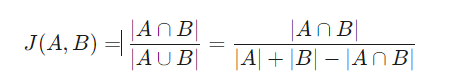

Đây là thước đo mức độ giống nhau của hai tập dữ liệu, với phạm vi từ 0% đến 100%. Tỷ lệ phần trăm càng cao thì hai tập càng giống nhau

In [45]:
#Load thư viện để so sánh khoảng cách giữa hai hoặc nhiều chuỗi bằng nhiều thuật toán
!pip install textdistance

In [46]:
import textdistance
df_clean['jaccard_sim_desc'] = df_clean['product_info'].map(lambda x:textdistance.jaccard(x.split('\t')[0],x.split('\t')[2]))
df_clean['jaccard_sim_title'] = df_clean['product_info'].map(lambda x:textdistance.jaccard(x.split('\t')[0],x.split('\t')[1]))

# Levenshtein distance
Khoảng cách Levenshtein thể hiện khoảng cách khác biệt giữa 2 chuỗi ký tự, là số bước ít nhất biến chuỗi thứ nhất thành chuỗi thứ 2 thông qua 3 phép biến đổi là:
* xoá 1 ký tự.
* thêm 1 ký tự.
* thay ký tự này bằng ký tự khác.

Khoảng cách Levenshtein bằng 0 có nghĩa là: cả hai chuỗi đều bằng nhau

In [47]:
df_clean['levenshtein_sim_desc'] = df_clean['product_info'].map(lambda x:textdistance.levenshtein(x.split('\t')[0],x.split('\t')[2]))
df_clean['levenshtein_sim_title'] = df_clean['product_info'].map(lambda x:textdistance.levenshtein(x.split('\t')[0],x.split('\t')[1]))

In [48]:
df_clean['mra_sim_desc'] = df_clean['product_info'].map(lambda x:textdistance.mra(x.split('\t')[0],x.split('\t')[2]))
df_clean['mra_sim_title'] = df_clean['product_info'].map(lambda x:textdistance.mra(x.split('\t')[0],x.split('\t')[1]))

In [49]:
df_brand = pd.unique(df_clean.brand.ravel())
d={}
i = 1000
for s in df_brand:
    d[s]=i
    i+=3
df_clean['brand_feature'] = df_clean['brand'].map(lambda x:d[x])
df_clean['search_term_feature'] = df_clean['search_term'].map(lambda x:len(x))

In [50]:
from nltk.corpus import brown
import gensim
embed_model = gensim.models.Word2Vec(brown.sents())
embed_model.save('brown.embedding')
model = gensim.models.Word2Vec.load('brown.embedding')

In [51]:
def embedding_sim_cal(s, t, i):
    _sum = 0
    avg = 0
    if len(s.split()) == 0 :
        return 0
    for s_word in s.split():
        _max = 0
        for t_word in t.split():
            if ((s_word in model.wv) and (t_word in model.wv)):
                _max = max(_max, model.wv.similarity(s_word, t_word))
        _sum += _max
    avg = _sum/ len(s.split())
    return avg

# Word embedding feature
Word Embedding là tên gọi chung của các mô hình ngôn ngữ và các phương pháp học theo đặc trưng trong Xử lý ngôn ngữ tự nhiên(NLP), ở đó các từ hoặc cụm từ được ánh xạ sang các vector số (thường là số thực) Word2vec là một trong những kỹ thuật phổ biến nhất để học cách nhúng từ bằng cách sử dụng mạng nơ-ron hai lớp. Đầu vào của nó là một kho văn bản và đầu ra của nó là một tập hợp các vectơ. Nhúng từ thông qua word2vec có thể làm cho máy tính có thể đọc được ngôn ngữ tự nhiên, sau đó có thể sử dụng thêm việc triển khai các phép toán trên các từ để phát hiện các điểm tương đồng của chúng. Một tập hợp các vectơ từ được đào tạo tốt sẽ đặt các từ tương tự gần nhau trong không gian đó 

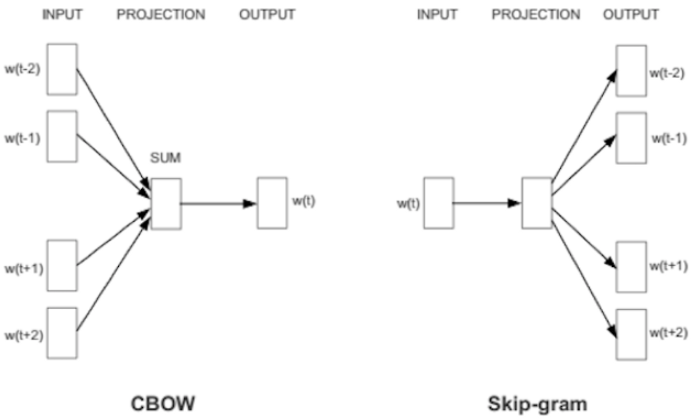

Có 2 thuật toán huấn luyện chính cho word2vec là CBOW và Skip-gram Thư viện Gensim Python Gensim là một thư viện python mã nguồn mở để xử lý ngôn ngữ tự nhiên. Thư viện Gensim sẽ cho phép phát triển Word embedding feature bằng cách đào tạo các mô hình word2vec của riêng chúng ta trên kho dữ liệu tùy chỉnh với CBOW của thuật toán skip-grams.

In [52]:
df_clean['word_ebed_similarity'] = df_clean['product_info'].map(lambda x:embedding_sim_cal(x.split('\t')[0],x.split('\t')[2],0))
df_clean.to_csv('df_final.csv')

# TF-IDF similarity measure feature
TF-IDF là viết tắt của “Term Frequency — Inverse Document Frequency” . Đây là một kỹ thuật để định lượng các từ trong một bộ tài liệu. Phương pháp này là một kỹ thuật được sử dụng rộng rãi trong Truy xuất Thông tin và Khai thác Văn bản. Các biến thể của lược đồ trọng số tf-idf thường được các công cụ tìm kiếm sử dụng để chấm điểm và xếp hạng mức độ liên quan của tài liệu khi đưa ra một truy vấn. Trọng số này là một thước đo thống kê được sử dụng để đánh giá mức độ quan trọng của một từ đối với một tài liệu trong một bộ sưu tập hoặc kho ngữ liệu. Mức độ quan trọng tăng tương ứng với số lần một từ xuất hiện trong tài liệu nhưng được bù đắp bởi tần suất xuất hiện của từ đó trong kho ngữ liệu (tập dữ liệu).TF-IDF có thể được tính theo công thức sau:

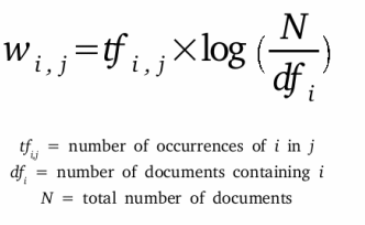

Term Frequency: đo tần suất xuất hiện của một từ trong tài liệu. Điều này phụ thuộc nhiều vào độ dài của tài liệu và tính tổng quát của từ
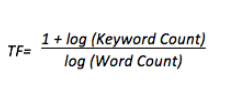

Document Frequency: đo lường tầm quan trọng của các tài liệu trong toàn bộ tập hợp ngữ liệu
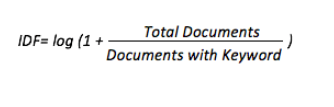

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range = (3,3), max_features = 1500)
tfidf_des = tfidf.fit_transform(df_clean.product_description).toarray()
tfidf_search = tfidf.transform(df_clean.search_term).toarray()
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')

# Modeling
**Loss function: RMSE**

Là hàm lỗi bình phương trung bình gốc. Nó đo độ lớn trung bình của các sai số và quan tâm đến độ lệch so với giá trị thực tế
Công thức:
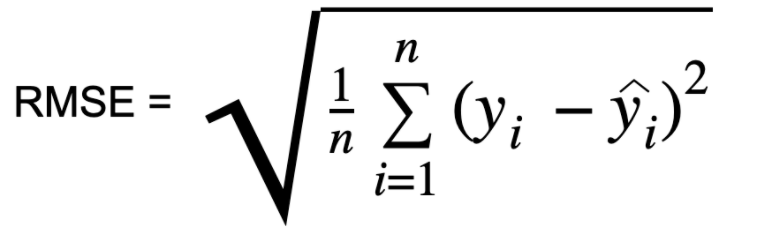
Giá trị RMSE bằng 0 chỉ ra rằng mô hình có sự phù hợp hoàn hảo. RMSE càng thấp, mô hình càng tốt và các dự đoán của nó. RMSE cao hơn chỉ ra rằng có một độ lệch lớn từ giá trị còn lại đến chân lý cơ bản. RMSE có thể được sử dụng với các tính năng khác nhau vì nó giúp tìm ra liệu tính năng có cải thiện dự đoán của mô hình hay không

In [54]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

In [55]:
class custom_regression_vals(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    def transform(self, hd_searches):
        d_col_drops=['id','relevance','search_term','product_title','product_description','product_info','attr','brand']
        hd_searches = hd_searches.drop(d_col_drops,axis=1).values
        return hd_searches
class custom_txt_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key].apply(str)

In [56]:
df_train = df_clean.iloc[:num_train]
df_test = df_clean.iloc[num_train:]
id_test = df_test['id']
y_train = df_train['relevance'].values
X_train = df_train[:]
X_test = df_test[:]

# RandomforestRegesssor
**A random forest regressor.**
là một kỹ thuật tổng hợp có khả năng thực hiện cả nhiệm vụ hồi quy và phân loại với việc sử dụng nhiều cây quyết định và một kỹ thuật gọi là Bootstrap and Aggregation, thường được gọi là bagging 

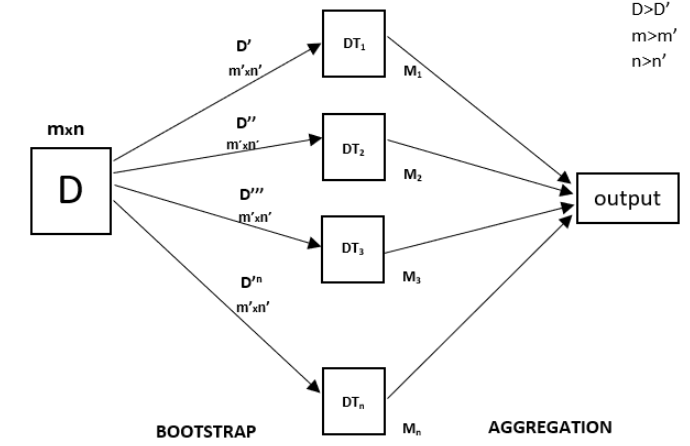

Hyperparametters được sử dụng:
* n_estimators: Số lượng cây trong rừng.
* n_jobs: Số lượng công việc sẽ chạy song song.
* random_state: Kiểm soát cả tính ngẫu nhiên của bootstrapping của các mẫu được sử dụng khi xây dựng cây (nếu bootstrap = True) và việc lấy mẫu các tính năng cần xem xét khi tìm kiếm sự phân tách tốt nhất tại mỗi nút (nếu max_features <n_features)
* verbose: Kiểm soát độ dài khi điều chỉnh và dự đoán

In [57]:
rfr = RandomForestRegressor(n_estimators = 530, n_jobs = -1, random_state = 2016, verbose = 1)

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

Dimensionality reduction Sử dụng phương pháp phân hủy giá trị kỳ dị cắt ngắn (SVD)để giảm kích thước

In [59]:
tsvd = TruncatedSVD(n_components=10, random_state = 2016)

In [60]:
clf = pipeline.Pipeline([
        ('union', FeatureUnion(
                    transformer_list = [
                        ('cst',  custom_regression_vals()),  
                        ('txt1', pipeline.Pipeline([('s1', custom_txt_col(key='search_term')), ('tfidf1', tfidf), ('tsvd1', tsvd)])),
                        ('txt2', pipeline.Pipeline([('s2', custom_txt_col(key='product_title')), ('tfidf2', tfidf), ('tsvd2', tsvd)])),
                        ('txt3', pipeline.Pipeline([('s3', custom_txt_col(key='product_description')), ('tfidf3', tfidf), ('tsvd3', tsvd)])),
                        ('txt4', pipeline.Pipeline([('s4', custom_txt_col(key='brand')), ('tfidf4', tfidf), ('tsvd4', tsvd)]))],
                    transformer_weights = {
                        'cst': 1.0,
                        'txt1': 0.5,
                        'txt2': 0.25,
                        'txt3': 0.01,
                        'txt4': 0.5
                        },
                #n_jobs = -1
                )), 
        ('rfr', rfr)])
param_grid = {'rfr__max_features': [8], 'rfr__max_depth': [18]}

# GridSearchCV
Là một hàm thư viện là một thành viên của gói model_selection của sklearn. Nó giúp lặp lại các siêu tham số được xác định trước và phù hợp với công cụ ước tính (mô hình) của bạn trên train. Vì vậy, cuối cùng, bạn có thể chọn các tham số tốt nhất từ các siêu tham số được liệt kê. Hyperparametters used:

* estimator: đối tượng ước tính đang được sử dụng
* param_grid: từ điển chứa tất cả các tham số để thử
* scoring: số liệu đánh giá để sử dụng khi xếp hạng kết quả
* cv: xác nhận chéo, số lần gấp cv cho mỗi tổ hợp các tham số

In [61]:
model = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1, cv = 2, verbose = 20, scoring=RMSE)
results=model.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 530 out of 530 | elapsed:  1.6min finished


In [62]:
def plot_scores_single(results, param, log=False):
    X = [x[param] for x in results.cv_results_['params']]
    if log:
        X = [math.log10(a) for a in X]
    plt.plot(X, -results.cv_results_['mean_train_score'])
    plt.plot(X, -results.cv_results_['mean_test_score'])
    plt.title('rmse')
    plt.ylabel('rmse')
    plt.xlabel(param)
    plt.legend(['train', 'tets'], loc='lower left')
    plt.show()

In [63]:
# plot_scores_single(results, 'alpha', log=True)

In [64]:
pd.DataFrame({"id": id_test, "relevance": model.predict(X_test)}).to_csv('submission.csv',index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 530 out of 530 | elapsed:    6.0s finished
